In [1]:
import sys
sys.path.append("../src")

import os

import cv2
import imgviz
import pyvips
import numpy as np
from empatches import EMPatches
import matplotlib.pyplot as plt
from utils import (
    pad_img,
    get_args, 
    patchify,
    save_patches,
    save_patch_args, 
    get_target_shape,
    get_nearest_multiple
    )

/Users/ericmonzon/mambaforge/envs/histology/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = os.path.join("..", "..", "raw-data", "images")
image_names = os.listdir(data_dir)

print("num images:", len(image_names))

num images: 127


In [3]:
image_paths = [os.path.join(data_dir, i) for i in image_names]

In [4]:
slide = pyvips.Image.new_from_file(image_paths[0])

In [5]:
(slide.height, slide.width)

(23663, 21566)

In [6]:
wsi = slide.numpy()

wsi.shape

(23663, 21566, 3)

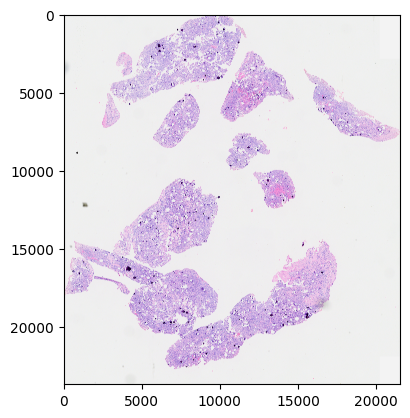

In [7]:
plt.imshow(wsi)
plt.show()

In [8]:
emp = EMPatches()
image_patches, indices = emp.extract_patches(wsi, patchsize=224, overlap=0)

In [9]:
def valid_patch(patch, threshold):
    gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
    _, background_mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    white_pixels = np.sum(background_mask == 255)
    total_pixels = patch.shape[0] * patch.shape[1]

    background_composition = white_pixels / total_pixels

    validity = bool(background_composition < 0.8)

    return validity

In [10]:
image_patches[500].shape

(224, 224, 3)

In [11]:
valid_patch(image_patches[501], threshold=230)

True

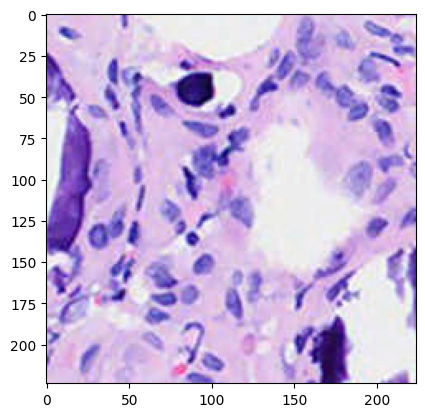

In [12]:
plt.imshow(image_patches[501])

In [14]:
new_size = (32, 32)
resized_image_patches = [cv2.resize(image, new_size) for image in image_patches]
resized_image_patches = [patch if valid_patch(patch, 230) else np.zeros_like(patch) for patch in resized_image_patches]

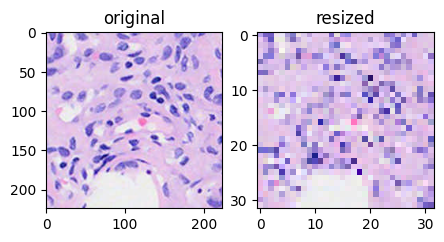

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(5,10))

axes[0].imshow(image_patches[500])
axes[0].set_title("original")

axes[1].imshow(resized_image_patches[500])
axes[1].set_title("resized")

plt.show()

In [16]:
permutation = np.random.permutation(len(indices))

In [17]:
combined = list(zip(resized_image_patches, indices))

np.random.shuffle(combined)

shuffled_patches, shuffled_coords = zip(*combined)

shuffled_patches = list(shuffled_patches)
shuffled_coords = list(shuffled_coords)

In [18]:
def get_checkpoint(indices):
    for i, index in enumerate(indices):
        if index[2] != 0:
            checkpoint = i
            
            return checkpoint

In [19]:
get_checkpoint(shuffled_coords)

0

In [20]:
# get_checkpoint(sorted(shuffled_coords, key=lambda x: (x[2], x[3], x[0], x[1])))

combined = list(zip(shuffled_patches, shuffled_coords))

sorted_combined = sorted(combined, key=lambda x: (x[1][2], x[1][3], x[1][0], x[1][1]))

sorted_patches, sorted_coords = zip(*sorted_combined)

sorted_patches = list(sorted_patches)
sorted_coords = list(sorted_coords)


In [21]:
def adjust_indices(indices, new_size):
    checkpoint = get_checkpoint(indices)
    placeholder = [0, new_size, 0, new_size]
    new_indices = []

    for i in range(len(indices)):
        if i % checkpoint == 0 and i > 0:
            placeholder[0] = 0
            placeholder[1] = new_size

            placeholder[2] += new_size
            placeholder[3] += new_size

        y1, y2, = placeholder[0], placeholder[1]
        x1, x2 = placeholder[2], placeholder[3]
        new_indices.append((y1, y2, x1, x2))

        placeholder[0] += new_size
        placeholder[1] += new_size

    return new_indices

In [22]:
new_indices = adjust_indices(sorted_coords, new_size[0])

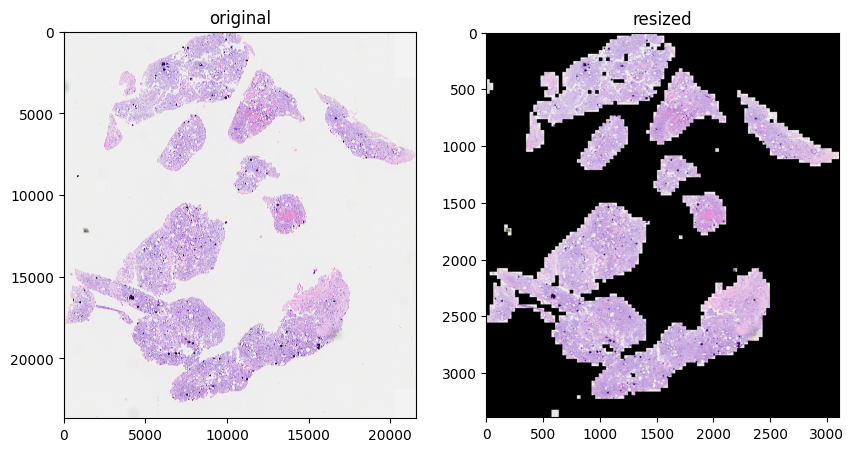

In [23]:
merged_max = emp.merge_patches(image_patches, indices, mode='max').astype(int)
new_merged_max = emp.merge_patches(resized_image_patches, new_indices, mode='max').astype("uint8")

fig, axes = plt.subplots(1, 2, figsize=(10,20))

axes[0].imshow(merged_max)
axes[0].set_title("original")

axes[1].imshow(new_merged_max)
axes[1].set_title("resized")

plt.show()

In [ ]:
patch_size = 224

target_shape = get_target_shape(wsi, patch_size)

if target_shape != wsi.shape[:2]:
    test_img = wsi.copy()
    test_img = pad_img(test_img, target_shape)

In [ ]:
target_shape

(54208, 46816)

In [ ]:
# get_nearest_multiple(25088 // 224, 224) *224

In [ ]:
wsi.shape

(54082, 46680, 3)

In [ ]:
test_img.shape

(23744, 21728, 3)

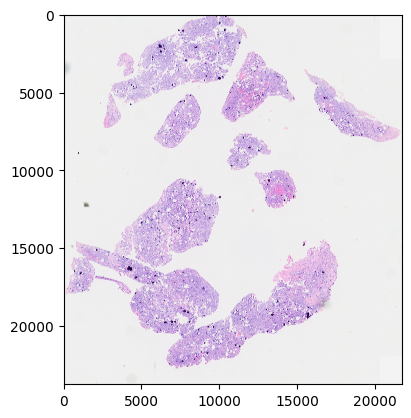

In [ ]:
plt.imshow(test_img)
plt.show()

In [ ]:
plt.imsave("test.png", test_img)

In [ ]:
test_img.shape

(23743, 21728, 3)